In [2]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions23 import *

In [3]:
pathout = '/home/jvalenti/MOAD/results/'
path_bat = '/home/jvalenti/MOAD/grid/bathymetry_202108.nc'
bat = xr.open_dataset(path_bat,decode_times=False).Bathymetry

In [4]:
path_d='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_T.nc'
path_d2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_w='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_W.nc'
path_w2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_W.nc'
path_u='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_U.nc'
path_v='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_V.nc'

path_mask = '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc'
e3t = xr.open_dataset(path_d,decode_times=False).e3t
e3t2 = xr.open_dataset(path_d2,decode_times=False).e3t
e3t = xr.concat([e3t,e3t2],dim='time_counter')
Area = xr.open_dataset(path_area,decode_times=False).area
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
zz_ww = xr.open_dataset(path_mask,decode_times=False).gdepw_0
e3t0 = xr.open_dataset(path_mask,decode_times=False).e3t_0

In [5]:
ssh = xr.open_dataset(path_d,decode_times=False).sossheig[:,300,297:302]
ssh2 = xr.open_dataset(path_d2,decode_times=False).sossheig[:,300,297:302]
ssh = xr.concat([ssh,ssh2],dim='time_counter')
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy[0,300,297:302]
u = xr.open_dataset(path_u,decode_times=False).vozocrtx[:,:,300,297:302]
w = xr.open_dataset(path_w,decode_times=False).vovecrtz[:,:,300,297:302]
w2 = xr.open_dataset(path_w2,decode_times=False).vovecrtz[:,:,300,297:302]
w = xr.concat([w,w2],dim='time_counter')
depthw = xr.open_dataset(path_w,decode_times=False).depthw
depthu = xr.open_dataset(path_u,decode_times=False).depthu
totaldepth = zz_ww[0, mbathy,300, 297:302]

In [18]:
z0 = np.array(depthw[:int(mbathy[3])])
td = totaldepth[3].item()
sshn = ssh[10,3].item()
prod = 1+sshn/td

def wssh(z):
    return sshn*(1-z/td)
sigma = td - z0*prod + sshn 
sigma0 = td - z0*prod
sigmat = sigma - wssh(z0)

In [19]:
sigmat-sigma0

array([-9.53674316e-07, -1.15989685e-01, -2.31980324e-01, -3.47971916e-01,
       -4.63963509e-01, -5.79959869e-01, -6.95962906e-01, -8.11978340e-01,
       -9.28019047e-01, -1.04410839e+00, -1.16029167e+00, -1.27665901e+00,
       -1.39338470e+00, -1.51080775e+00, -1.62958848e+00], dtype=float32)

In [ ]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
#lonu = np.array([500.,1000., 1500.,2000.,2500])
#latv = np.array([500.,1000.])
#lat = np.array([250.,750])
time = np.linspace(0,2*86400,48)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
#U = Field('U', u, lon=lonu, lat=None, depth=depthu, time=time)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
W = Field('W', w, lon=lon, lat=None, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=None, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=None, depth=None, time=None)

In [ ]:
fieldset = FieldSet(U,V)
fieldset.add_field(W)
fieldset.add_field(SSH)
fieldset.add_field(Td)

In [ ]:
class MPParticle(JITParticle):
    fact = Variable('fact', initial =  1.0) 
class MPParticle2(JITParticle):
    fact = Variable('fact', initial =  0.0) 

In [ ]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [ ]:
def Advection(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    if particle.fact == 1:
        factor = (1+ssh/td)
    else:
        factor=1
    (u1, v1, w1) = fieldset.UVW[time, particle.depth/factor, particle.lat, particle.lon]
    lon1 = particle.lon + u1*.5*particle.dt
    lat1 = particle.lat + v1*.5*particle.dt
    dep1 = particle.depth + w1*.5*particle.dt/factor
    (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1/factor, lat1, lon1]
    lon2 = particle.lon + u2*.5*particle.dt
    lat2 = particle.lat + v2*.5*particle.dt
    dep2 = particle.depth + w2*.5*particle.dt/factor
    (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2/factor, lat2, lon2]
    lon3 = particle.lon + u3*particle.dt
    lat3 = particle.lat + v3*particle.dt
    dep3 = particle.depth + w3*particle.dt/factor
    (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3/factor, lat3, lon3]
    particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    particle.depth += (w1 + 2*w2 + 2*w3 + w4) / 6. * particle.dt/factor

In [ ]:
n = 500
KE=Advection
lon_g = np.random.uniform(low=250, high=2000, size=(n,))
depth_g = np.random.uniform(low=0.5, high=30, size=(n,))
lat_g = np.ones(n,)*750
pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
pset2 = ParticleSet(fieldset, pclass=MPParticle2, lon=lon_g, depth=depth_g,lat = lat_g)
output_file = pset.ParticleFile(name=pathout+'Output.zarr', outputdt=3600)
output_file2 = pset2.ParticleFile(name=pathout+'Output2.zarr', outputdt=3600)
pset.execute(KE , runtime=2*86400, dt=10, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
pset2.execute(KE , runtime=2*86400, dt=10, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayMPParticleAdvection ==> /tmp/parcels-2894/lib83efdbb2d4341817c0b355e5cc5b54de_0.so


Particle 1127 lost !! [0.0, 0.505084216594696, 750.0, 1025.6934814453125]
Particle 1347 lost !! [650.0, 0.508597195148468, 750.0, 792.1727294921875]
Particle 1195 lost !! [5950.0, 0.5148448348045349, 750.0, 540.799072265625]
Particle 1238 lost !! [6150.0, 0.5160292983055115, 750.0, 285.9242248535156]
Particle 1270 lost !! [5790.0, 0.514823317527771, 750.0, 534.825439453125]
Particle 1367 lost !! [18260.0, 0.5032179355621338, 750.0, 1613.479248046875]


INFO: Output files are stored in Output.zarr.
100%|██████████| 172800.0/172800.0 [00:06<00:00, 25218.99it/s] 
INFO: Compiled ArrayMPParticle2Advection ==> /tmp/parcels-2894/lib55557e80986f773fb97e202dbffdea9c_0.so


Particle 1847 lost !! [810.0, 0.5000236630439758, 750.0, 792.1727294921875]
Particle 1738 lost !! [6280.0, 0.5001013278961182, 750.0, 285.9242248535156]
Particle 1770 lost !! [6310.0, 0.5000351071357727, 750.0, 534.825439453125]
Particle 1867 lost !! [17740.0, 0.5001620650291443, 750.0, 1613.479248046875]


INFO: Output files are stored in Output2.zarr.
100%|██████████| 172800.0/172800.0 [00:06<00:00, 25757.17it/s] 


In [ ]:
dat = xr.load_dataset(pathout+'Output.zarr')
dat2 = xr.load_dataset(pathout+'Output2.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [ ]:
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
def profdif(t):
    i = 300
    j = 299
    kmax = int(mbathy[0,i,j].item())
    dA = np.cumsum(e3t[t,:kmax,i,j])
    dC = np.cumsum(e3t0[0,:kmax,i,j])
    i = 300
    j = 300
    kmax = int(mbathy[0,i,j].item())
    dB = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 298
    kmax = int(mbathy[0,i,j].item())
    dD = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 297
    kmax = int(mbathy[0,i,j].item())
    dE = np.cumsum(e3t[t,:kmax,i,j])
    return dA,dB,dC,dD,dE
def ploting(axs,t):
    dA,dB,dC,dD,dE = profdif(t)
    for i in range(len(dA)):
        axs.axhline(y=-dA[i],xmin=0.5,xmax=0.75)
    for i in range(len(dB)):
        axs.axhline(y=-dB[i],xmin=0.75,xmax=1)
    #for i in range(len(dC)):
    #   axs.axhline(y=-dC[i],c='r',alpha = 0.2)
    for i in range(len(dD)):
       axs.axhline(y=-dD[i],xmin=0.25,xmax=0.5)
    for i in range(len(dE)):
       axs.axhline(y=-dE[i],xmin=0,xmax=0.25)
    
    #plt.fill_between(np.linspace(0,500,len(dA)), -np.ones(len(dA))*float(dA[-1]),-np.ones(len(dA))*float(dA[-1])-5, color='brown',zorder=5,alpha = 0.3) 
    #plt.fill_between(np.linspace(500,1000,len(dB)), -np.ones(len(dB))*float(dB[-1]),-np.ones(len(dB))*float(dB[-1])-15, color='brown',zorder=5,alpha = 0.3)  
    #plt.xlim([0,2000])
    plt.ylim([-28,0])

In [ ]:
def anim2(file1,file2,fps=1):  
    #box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,1,figsize=(10,5))
    #axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
   
    #axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    #axs[1].plot(box[0],box[1],c='grey',linewidth=3)

    #axs[0].invert_yaxis()
    #axs[0].set_title('Initial condition (t: 0s)')
    axs.set_ylabel('Depth (m)')
    lent = np.linspace(0,48,len(file1.lon[0,:]))
    lent[-1]=lent[-2]
    def update(frame):              
        axs.clear()
        #axs[1].clear()
        axs.invert_yaxis()
        axs.set_title("Blue points z-stretch corrected")                 
        axs.scatter(file1.lon[:,frame],-file1.z[:,frame],s=5)
        #axs[1].invert_yaxis()
        #axs[1].set_title("Without e3t correction")                 
        axs.scatter(file2.lon[:,frame],-file2.z[:,frame],s=5)
        ploting(axs,round(lent[frame]))
        #ploting(axs[1],round(lent[frame]))
        axs.set_xlim([0,2000])
        axs.set_ylim([-30,0])       
        #axs[1].set_xlim([0,2000])
        #axs[1].set_ylim([-30,0])                 
        return 
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1.lon[0,:]),fps))

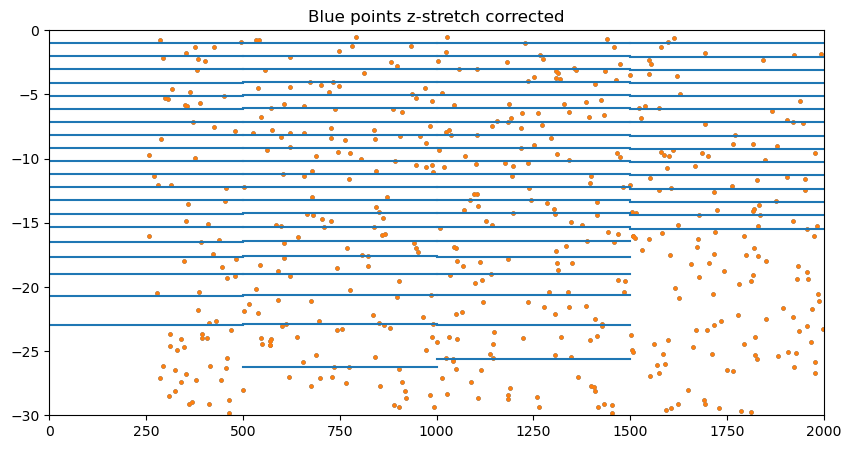

In [ ]:
ss =[]
ani = anim2(dat,dat2,fps=1)
f = r"/home/jvalenti/MOAD/animations/box.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

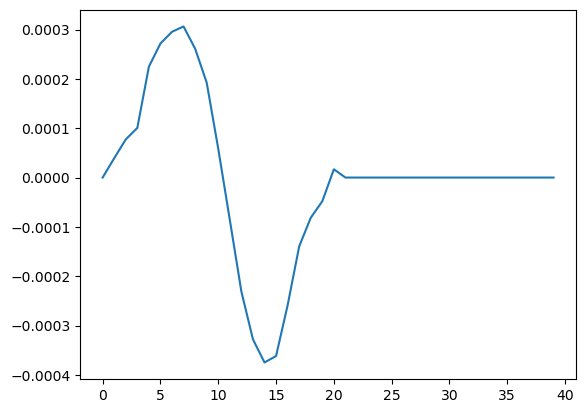

In [ ]:
plt.plot(w[10,:,1])

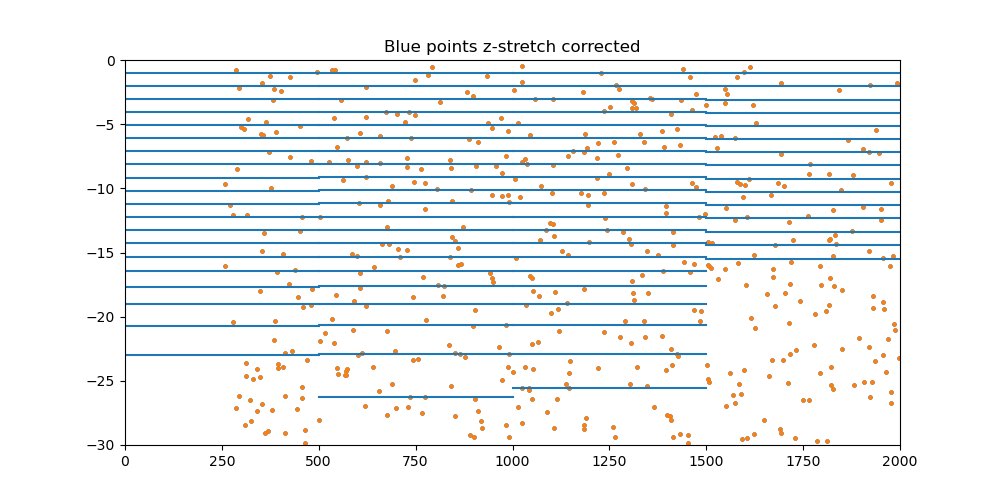

In [ ]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [ ]:
# fig = plt.figure(figsize=(4,7))
# def update(frame):
#         fr = round(frame)
#         plt.clf()
#         ploting(fr)
# anim = animation.FuncAnimation(fig, update, frames=np.arange(0,23,1))
# f2 = r"/home/jvalenti/MOAD/animations/anim.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f2, writer = FFwriter)

In [ ]:
# with open(f2,'rb') as anim:
#      display(Image(anim.read()))